# Predicting Energy Consumption with XGBoost

Regression analysis can be used to model the relationship between a dependent variable and one or more independent variables. 
- In the context of time series analysis, regression can be used to model the relationship between a time series variable and one or more predictor variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

Lets read and show the data

In [2]:
df = pd.read_csv('data/PJME_hourly.csv')
df = df.set_index("Datetime")
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


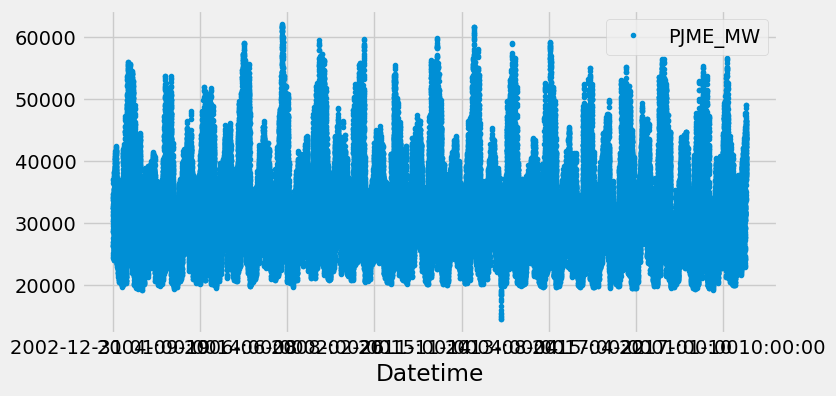

In [3]:
df.plot(figsize=(8,4), style='.')
plt.show()

In [4]:
df.index

Index(['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
       '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
       '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
       '2002-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=145366)

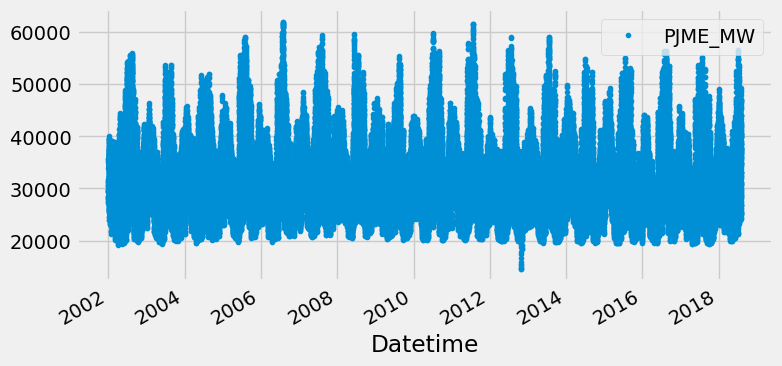

In [5]:
df.index = pd.to_datetime(df.index)
df.plot(figsize=(8,4), style='.')
plt.show()

## Train / Test Split

Unlike traditional train/test splitting, where the data is randomly divided into training and testing sets, in time series analysis, the data is split in chronological order, such that the training set includes data from earlier time periods and the testing set includes data from later time periods.

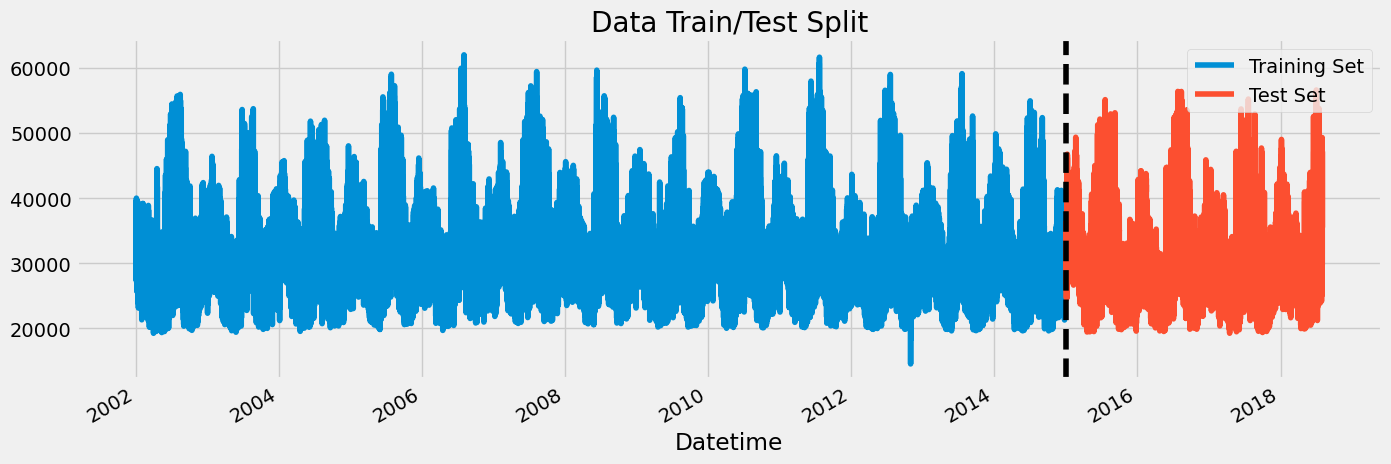

In [6]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

What does a single week of data looks like?

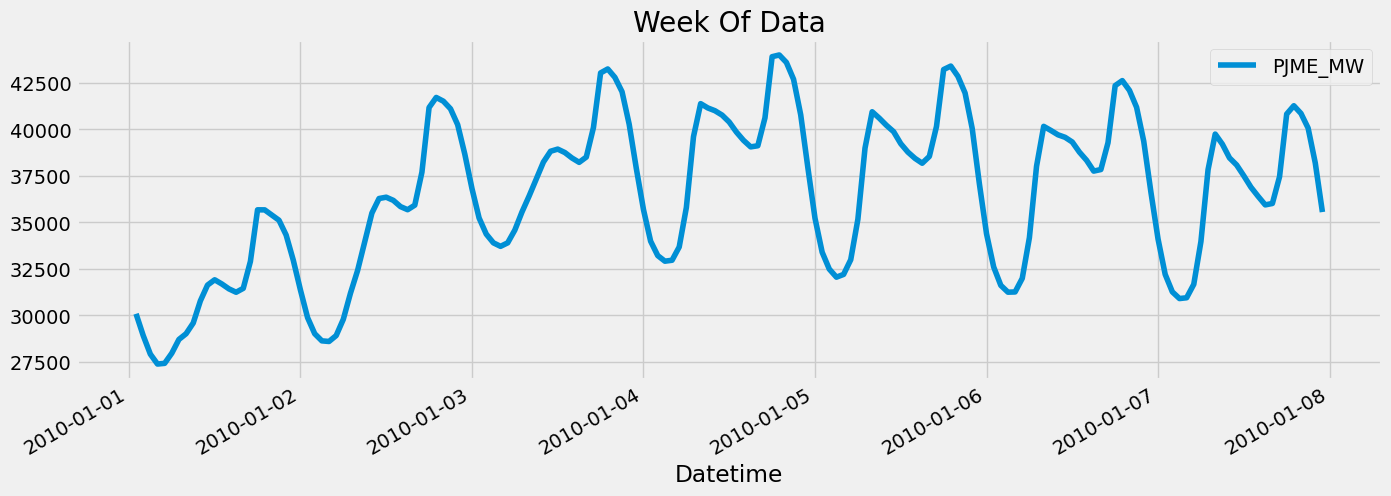

In [7]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

Now, lets create some features that are relevant to the forecasting, and that are related to the date

In [8]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


### Visualize our Feature / Target Relationship

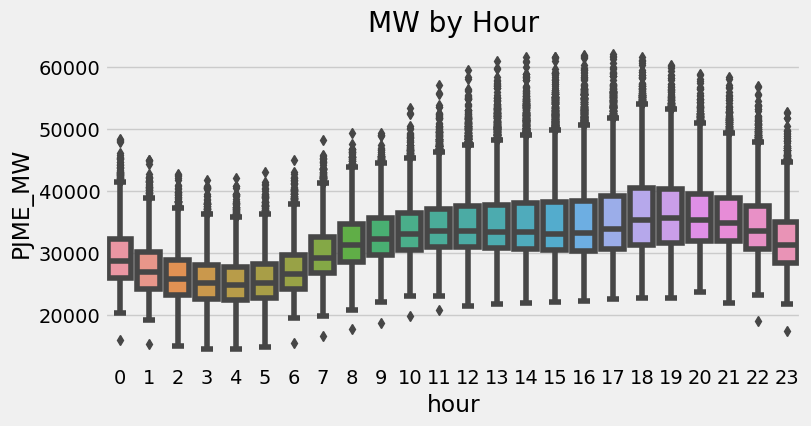

In [10]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

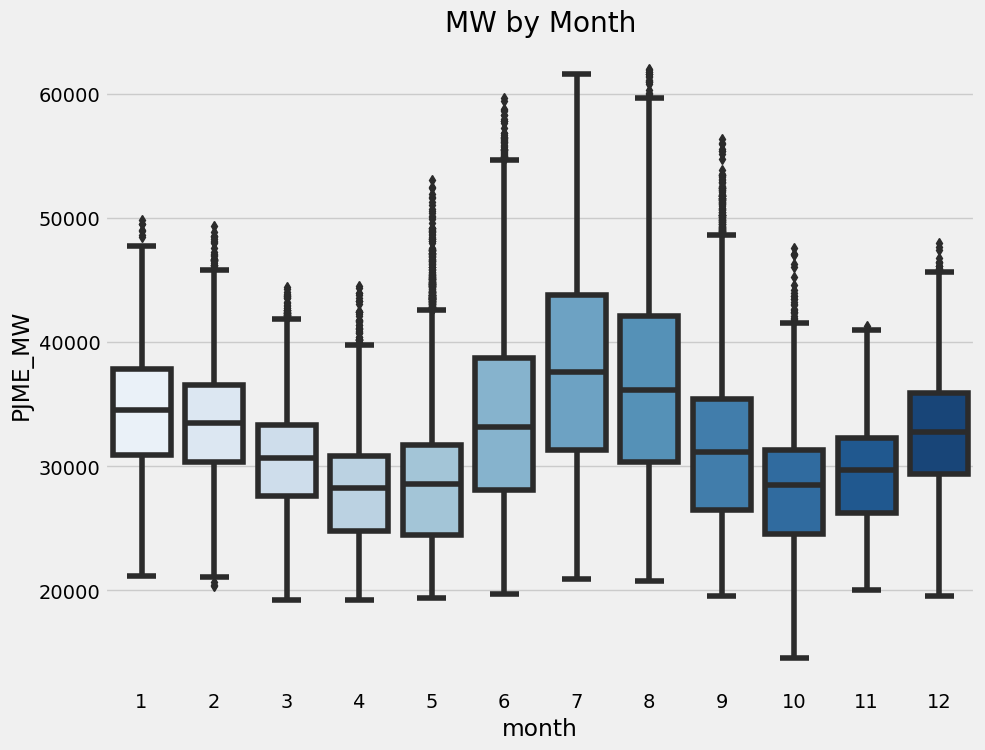

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

## Create our Model

In [14]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

We will use XGB regressor, a very powerfull classifier based on decision trees and boosting

In [18]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],        
        verbose=True)

[0]	validation_0-rmse:23192.08347	validation_1-rmse:22262.72116
[60]	validation_0-rmse:1938.07648	validation_1-rmse:4235.75258


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

You can see that the error in the validation set starts to increase, so we have overfitted the model.

Lets try with a small learning rate to move slower ..

In [20]:
reg = xgb.XGBRegressor(n_estimators=1000, 
                       early_stopping_rounds=50, learning_rate=0.001)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],        
        verbose=True)

[0]	validation_0-rmse:32894.63731	validation_1-rmse:31946.77347
[1]	validation_0-rmse:32862.13946	validation_1-rmse:31914.30561
[2]	validation_0-rmse:32829.67435	validation_1-rmse:31881.87054
[3]	validation_0-rmse:32797.24201	validation_1-rmse:31849.46849
[4]	validation_0-rmse:32764.84313	validation_1-rmse:31817.09987
[5]	validation_0-rmse:32732.47614	validation_1-rmse:31784.76356
[6]	validation_0-rmse:32700.14381	validation_1-rmse:31752.46040
[7]	validation_0-rmse:32667.84245	validation_1-rmse:31720.18982
[8]	validation_0-rmse:32635.57392	validation_1-rmse:31687.95203
[9]	validation_0-rmse:32603.33921	validation_1-rmse:31655.74701
[10]	validation_0-rmse:32571.13619	validation_1-rmse:31623.57493
[11]	validation_0-rmse:32538.96533	validation_1-rmse:31591.43510
[12]	validation_0-rmse:32506.82788	validation_1-rmse:31559.32773
[13]	validation_0-rmse:32474.72246	validation_1-rmse:31527.26245
[14]	validation_0-rmse:32442.64933	validation_1-rmse:31495.22036
[15]	validation_0-rmse:32410.60967	

[126]	validation_0-rmse:29048.37289	validation_1-rmse:28093.92715
[127]	validation_0-rmse:29019.76174	validation_1-rmse:28065.22763
[128]	validation_0-rmse:28991.17909	validation_1-rmse:28036.51258
[129]	validation_0-rmse:28962.62524	validation_1-rmse:28007.87443
[130]	validation_0-rmse:28934.10045	validation_1-rmse:27979.36496
[131]	validation_0-rmse:28905.61271	validation_1-rmse:27950.84473
[132]	validation_0-rmse:28877.14589	validation_1-rmse:27922.28780
[133]	validation_0-rmse:28848.70896	validation_1-rmse:27893.79667
[134]	validation_0-rmse:28820.30005	validation_1-rmse:27865.31703
[135]	validation_0-rmse:28791.91934	validation_1-rmse:27836.87115
[136]	validation_0-rmse:28763.56914	validation_1-rmse:27808.43096
[137]	validation_0-rmse:28735.24618	validation_1-rmse:27780.01480
[138]	validation_0-rmse:28706.95279	validation_1-rmse:27751.61488
[139]	validation_0-rmse:28678.68777	validation_1-rmse:27723.24193
[140]	validation_0-rmse:28650.45911	validation_1-rmse:27695.00265
[141]	vali

[251]	validation_0-rmse:25687.78851	validation_1-rmse:24735.19770
[252]	validation_0-rmse:25662.58324	validation_1-rmse:24710.10869
[253]	validation_0-rmse:25637.41109	validation_1-rmse:24685.04938
[254]	validation_0-rmse:25612.25882	validation_1-rmse:24659.89514
[255]	validation_0-rmse:25587.13223	validation_1-rmse:24634.85508
[256]	validation_0-rmse:25562.02598	validation_1-rmse:24609.85834
[257]	validation_0-rmse:25536.95040	validation_1-rmse:24584.88343
[258]	validation_0-rmse:25511.89554	validation_1-rmse:24559.90996
[259]	validation_0-rmse:25486.87622	validation_1-rmse:24534.98064
[260]	validation_0-rmse:25461.87409	validation_1-rmse:24510.02552
[261]	validation_0-rmse:25436.89461	validation_1-rmse:24485.18295
[262]	validation_0-rmse:25411.94225	validation_1-rmse:24460.29033
[263]	validation_0-rmse:25387.01438	validation_1-rmse:24435.48723
[264]	validation_0-rmse:25362.11200	validation_1-rmse:24410.66567
[265]	validation_0-rmse:25337.23418	validation_1-rmse:24385.88544
[266]	vali

[376]	validation_0-rmse:22727.68776	validation_1-rmse:21785.93245
[377]	validation_0-rmse:22705.50186	validation_1-rmse:21763.76507
[378]	validation_0-rmse:22683.32979	validation_1-rmse:21741.67835
[379]	validation_0-rmse:22661.18167	validation_1-rmse:21719.63899
[380]	validation_0-rmse:22639.06381	validation_1-rmse:21697.64910
[381]	validation_0-rmse:22616.95892	validation_1-rmse:21675.60424
[382]	validation_0-rmse:22594.87761	validation_1-rmse:21653.66349
[383]	validation_0-rmse:22572.81921	validation_1-rmse:21631.69170
[384]	validation_0-rmse:22550.78256	validation_1-rmse:21609.73459
[385]	validation_0-rmse:22528.77692	validation_1-rmse:21587.74886
[386]	validation_0-rmse:22506.78550	validation_1-rmse:21565.91260
[387]	validation_0-rmse:22484.82469	validation_1-rmse:21544.06156
[388]	validation_0-rmse:22462.87737	validation_1-rmse:21522.17537
[389]	validation_0-rmse:22440.95345	validation_1-rmse:21500.39442
[390]	validation_0-rmse:22419.05181	validation_1-rmse:21478.57548
[391]	vali

[501]	validation_0-rmse:20122.00968	validation_1-rmse:19192.70155
[502]	validation_0-rmse:20102.47732	validation_1-rmse:19173.31548
[503]	validation_0-rmse:20082.96687	validation_1-rmse:19153.86513
[504]	validation_0-rmse:20063.48020	validation_1-rmse:19134.43537
[505]	validation_0-rmse:20044.00983	validation_1-rmse:19115.11637
[506]	validation_0-rmse:20024.55632	validation_1-rmse:19095.77938
[507]	validation_0-rmse:20005.12760	validation_1-rmse:19076.48523
[508]	validation_0-rmse:19985.71495	validation_1-rmse:19057.25771
[509]	validation_0-rmse:19966.32449	validation_1-rmse:19037.95950
[510]	validation_0-rmse:19946.95098	validation_1-rmse:19018.71032
[511]	validation_0-rmse:19927.59895	validation_1-rmse:18999.41183
[512]	validation_0-rmse:19908.26611	validation_1-rmse:18980.24901
[513]	validation_0-rmse:19888.95675	validation_1-rmse:18960.95648
[514]	validation_0-rmse:19869.66210	validation_1-rmse:18941.74305
[515]	validation_0-rmse:19850.39154	validation_1-rmse:18922.62506
[516]	vali

[626]	validation_0-rmse:17828.52618	validation_1-rmse:16927.09754
[627]	validation_0-rmse:17811.33404	validation_1-rmse:16910.18462
[628]	validation_0-rmse:17794.16088	validation_1-rmse:16893.29111
[629]	validation_0-rmse:17777.00423	validation_1-rmse:16876.41918
[630]	validation_0-rmse:17759.88530	validation_1-rmse:16859.38590
[631]	validation_0-rmse:17742.76281	validation_1-rmse:16842.54394
[632]	validation_0-rmse:17725.67637	validation_1-rmse:16825.66388
[633]	validation_0-rmse:17708.59414	validation_1-rmse:16808.94680
[634]	validation_0-rmse:17691.52264	validation_1-rmse:16792.16062
[635]	validation_0-rmse:17674.47550	validation_1-rmse:16775.39288
[636]	validation_0-rmse:17657.43994	validation_1-rmse:16758.64286
[637]	validation_0-rmse:17640.44528	validation_1-rmse:16741.80033
[638]	validation_0-rmse:17623.45122	validation_1-rmse:16725.13209
[639]	validation_0-rmse:17606.46944	validation_1-rmse:16708.43645
[640]	validation_0-rmse:17589.52405	validation_1-rmse:16691.68112
[641]	vali

[751]	validation_0-rmse:15812.13632	validation_1-rmse:14933.52600
[752]	validation_0-rmse:15797.03546	validation_1-rmse:14918.61521
[753]	validation_0-rmse:15781.94444	validation_1-rmse:14903.60146
[754]	validation_0-rmse:15766.87203	validation_1-rmse:14888.63807
[755]	validation_0-rmse:15751.81130	validation_1-rmse:14873.73519
[756]	validation_0-rmse:15736.77392	validation_1-rmse:14858.86772
[757]	validation_0-rmse:15721.74895	validation_1-rmse:14843.97173
[758]	validation_0-rmse:15706.73952	validation_1-rmse:14828.99558
[759]	validation_0-rmse:15691.74923	validation_1-rmse:14814.17041
[760]	validation_0-rmse:15676.76677	validation_1-rmse:14799.31122
[761]	validation_0-rmse:15661.80518	validation_1-rmse:14784.57231
[762]	validation_0-rmse:15646.85492	validation_1-rmse:14769.74427
[763]	validation_0-rmse:15631.92534	validation_1-rmse:14754.83916
[764]	validation_0-rmse:15617.00505	validation_1-rmse:14740.08690
[765]	validation_0-rmse:15602.10784	validation_1-rmse:14725.35426
[766]	vali

[876]	validation_0-rmse:14040.98276	validation_1-rmse:13182.69643
[877]	validation_0-rmse:14027.72831	validation_1-rmse:13169.61920
[878]	validation_0-rmse:14014.49017	validation_1-rmse:13156.43047
[879]	validation_0-rmse:14001.26812	validation_1-rmse:13143.43808
[880]	validation_0-rmse:13988.04991	validation_1-rmse:13130.42549
[881]	validation_0-rmse:13974.84734	validation_1-rmse:13117.37474
[882]	validation_0-rmse:13961.66612	validation_1-rmse:13104.45276
[883]	validation_0-rmse:13948.49575	validation_1-rmse:13091.42253
[884]	validation_0-rmse:13935.33513	validation_1-rmse:13078.42489
[885]	validation_0-rmse:13922.18776	validation_1-rmse:13065.51877
[886]	validation_0-rmse:13909.05779	validation_1-rmse:13052.55954
[887]	validation_0-rmse:13895.94462	validation_1-rmse:13039.54835
[888]	validation_0-rmse:13882.84681	validation_1-rmse:13026.68235
[889]	validation_0-rmse:13869.75454	validation_1-rmse:13013.74302
[890]	validation_0-rmse:13856.66956	validation_1-rmse:13000.97207
[891]	vali

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Lets change the verbose parameter, in order to reduce the clutter ...

In [21]:
reg = xgb.XGBRegressor(n_estimators=1000, 
                       early_stopping_rounds=50, learning_rate=0.001)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],        
        verbose=100)

[0]	validation_0-rmse:32894.63731	validation_1-rmse:31946.77347
[100]	validation_0-rmse:29802.40434	validation_1-rmse:28850.26957
[200]	validation_0-rmse:27007.68441	validation_1-rmse:26052.43931
[300]	validation_0-rmse:24482.32005	validation_1-rmse:23533.89183
[400]	validation_0-rmse:22201.28055	validation_1-rmse:21261.74073
[500]	validation_0-rmse:20141.56473	validation_1-rmse:19212.14293
[600]	validation_0-rmse:18281.64247	validation_1-rmse:17373.31404
[700]	validation_0-rmse:16603.51761	validation_1-rmse:15718.16953
[800]	validation_0-rmse:15090.22011	validation_1-rmse:14218.31995
[900]	validation_0-rmse:13726.67411	validation_1-rmse:12872.89007
[999]	validation_0-rmse:12510.64305	validation_1-rmse:11682.68908


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Lets move now a little faster in order to find a best solution

In [33]:
reg = xgb.XGBRegressor(n_estimators=1000, 
                       early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],        
        verbose=100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12341.93072	validation_1-rmse:11522.06347
[200]	validation_0-rmse:5373.23326	validation_1-rmse:5164.82201
[300]	validation_0-rmse:3377.06238	validation_1-rmse:3829.91316
[400]	validation_0-rmse:2877.98846	validation_1-rmse:3713.12414
[440]	validation_0-rmse:2785.25298	validation_1-rmse:3725.51793


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Feature Importance

In [22]:
reg.feature_importances_

array([0.11176902, 0.29084012, 0.15654907, 0.00870453, 0.4218928 ,
       0.01024453], dtype=float32)

Values are meaningless, so lets improve the visualization by creating a new dataframe

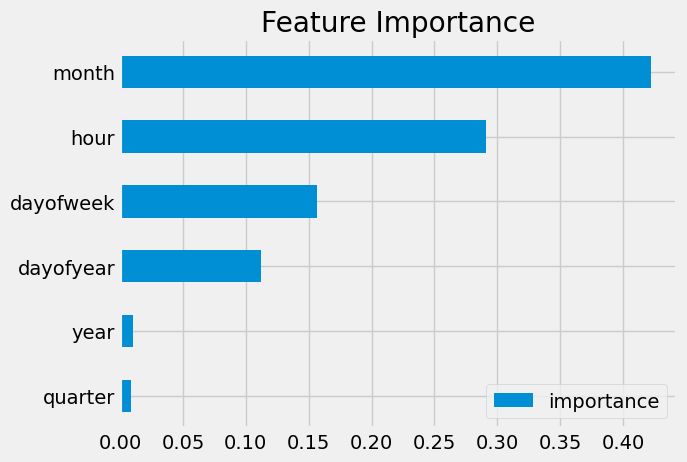

In [23]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Lets see the correlations between features ...

<Axes: >

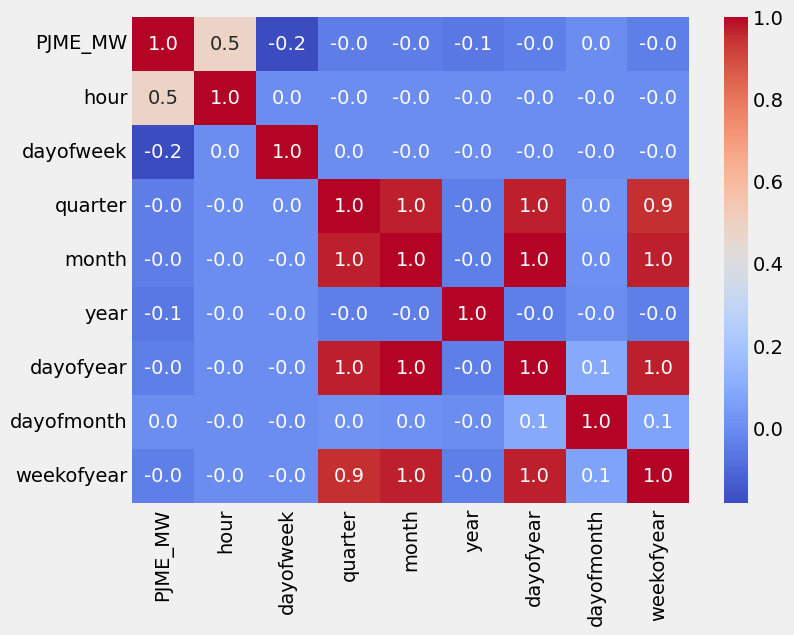

In [29]:
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.1f')

## Forecast on Test

In [36]:
y_pred = reg.predict(X_test)
y_pred

array([31969.053, 28255.934, 27129.057, ..., 34896.535, 33256.477,
       31969.053], dtype=float32)

For a better visualization, lets add the predicted values to the original dataset

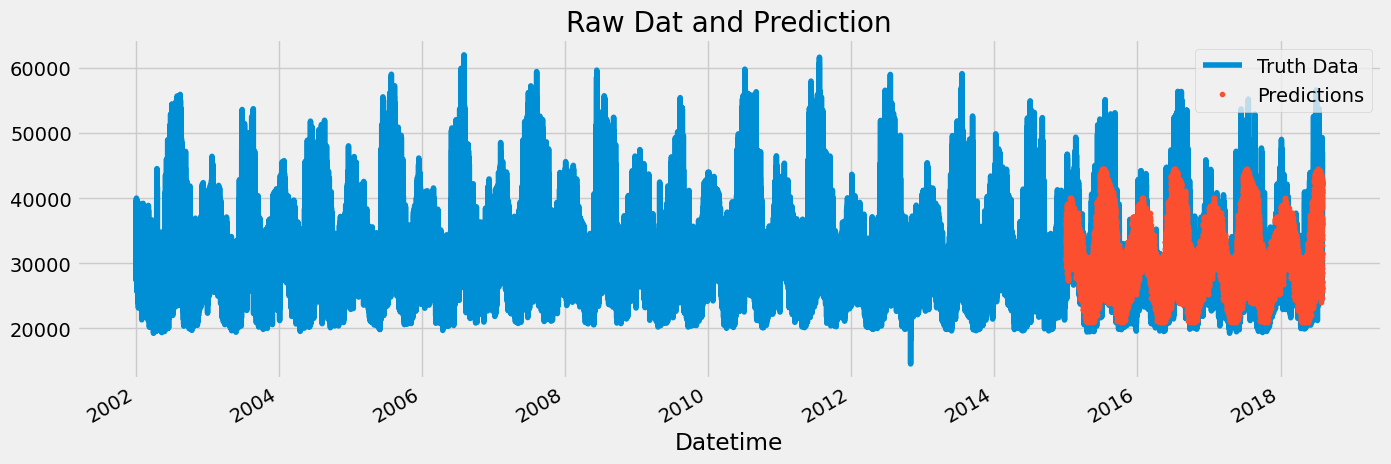

In [37]:
test['prediction'] = y_pred
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

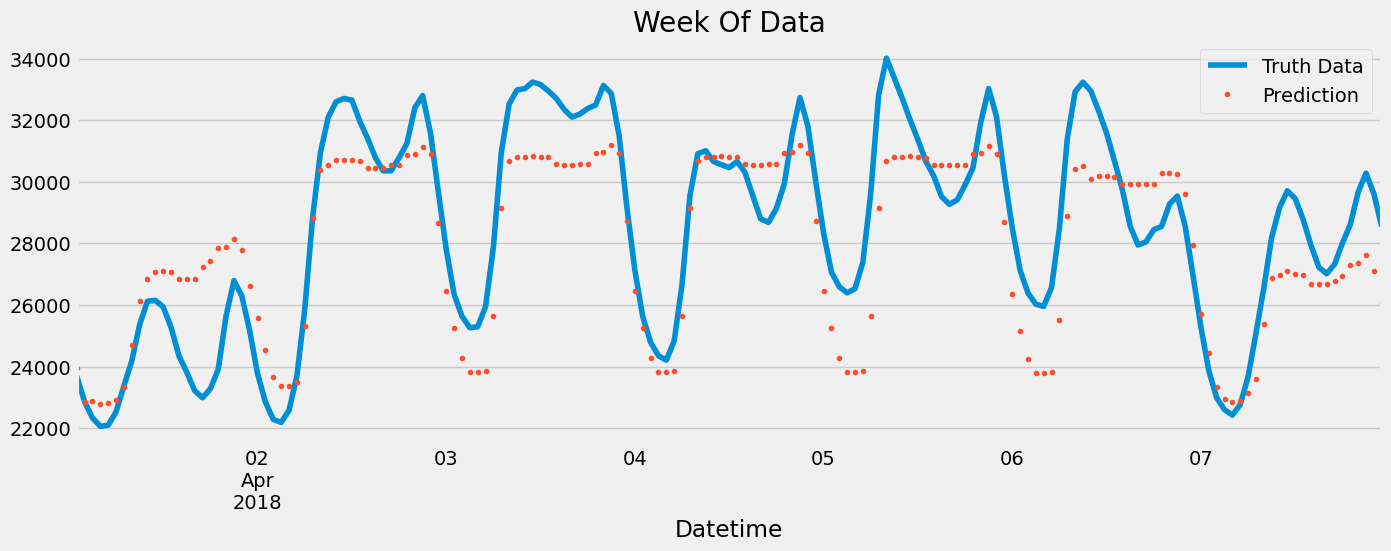

In [39]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

Results are not as good as they can be, but the regressor have managed to capture the seasonality.

## Score (RMSE)

In [40]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3712.34


Look at the worst predicted days ... where they hollidays?

In [41]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    14650.704508
2016-08-14    14538.611247
2016-09-10    12576.863607
2016-09-09    11522.881266
2016-08-12    11510.995850
2015-02-20    10841.270915
2018-01-06    10807.138916
2016-08-11    10404.905436
2017-05-19    10211.232259
2015-02-16    10126.586426
Name: error, dtype: float64

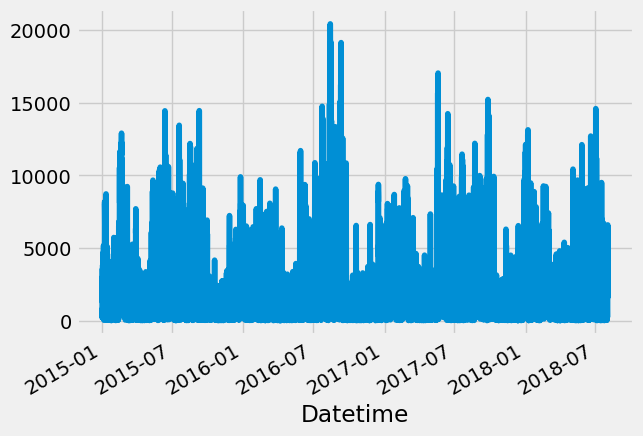

In [43]:
test.error.plot()
ax.set_title('Errors per day')
plt.show()

Lets zoom the errors in a year

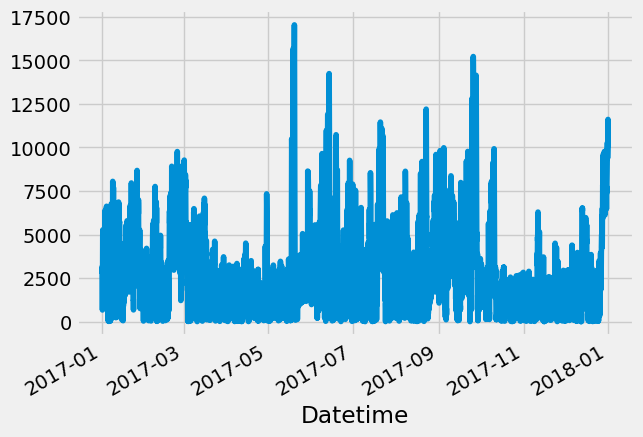

In [51]:
test.error.loc[(test.index > '01-01-2017') & (test.index < '01-01-2018')].plot()
ax.set_title('Errors per day in a year')
plt.show()

And zoom in a week

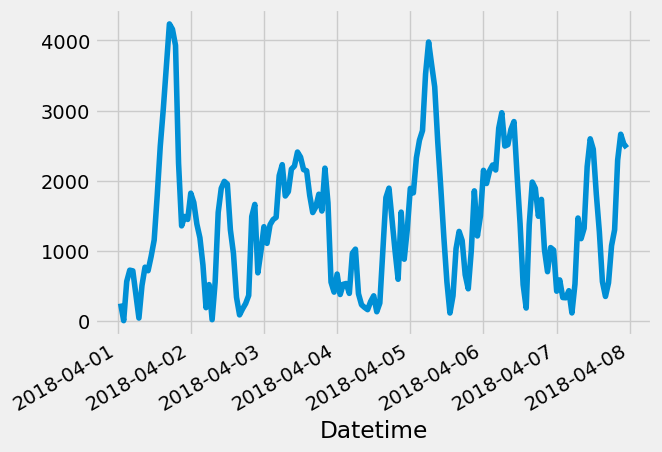

In [52]:
test.error.loc[(test.index > '04-01-2018') & (test.index < '04-08-2018')].plot()
ax.set_title('Errors per day in a week')
plt.show()

Plenty of room to improve:
- More robust cross validation
- Add more features (weather forecast, holidays)

## Outlier Analysis and removal

<Axes: ylabel='Frequency'>

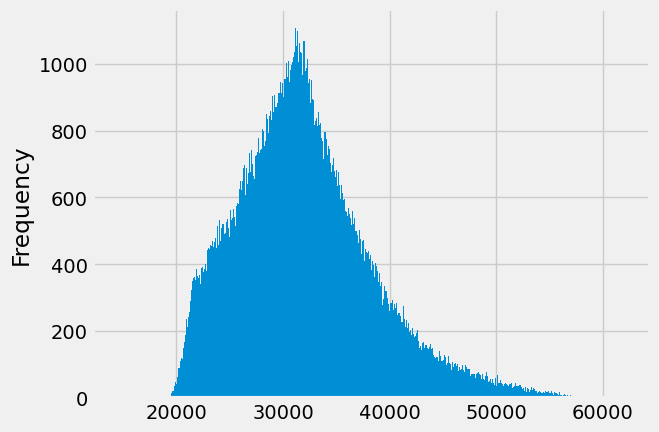

In [53]:
df['PJME_MW'].plot(kind='hist', bins=500)

Lets first consider those points with largest values

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

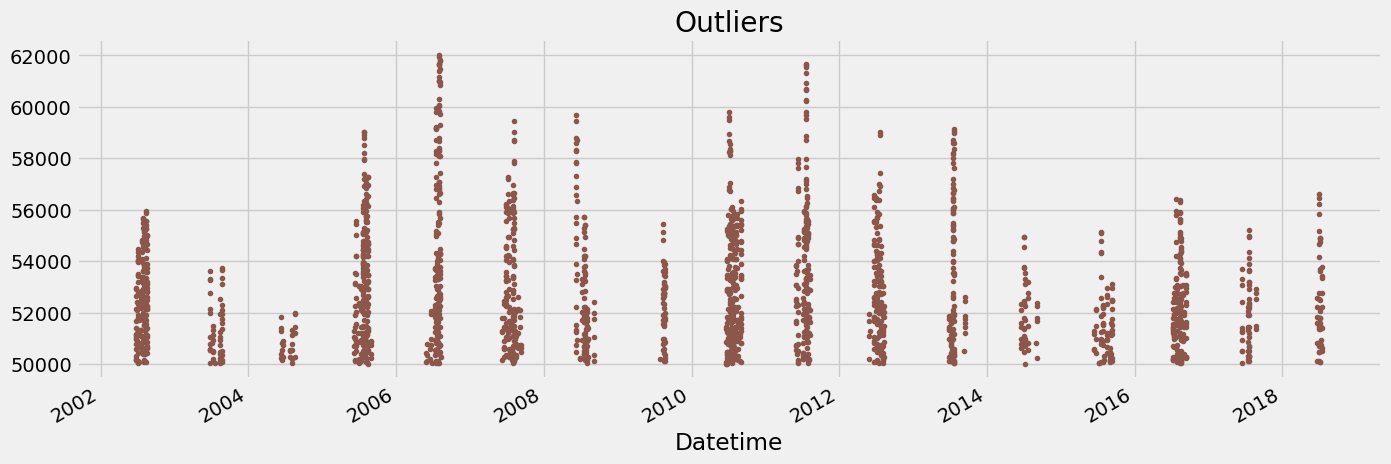

In [55]:
df.query('PJME_MW > 50_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

They are consistent with the times of the year where the demand is higher.

Now, lets see the days with lowest consumption

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

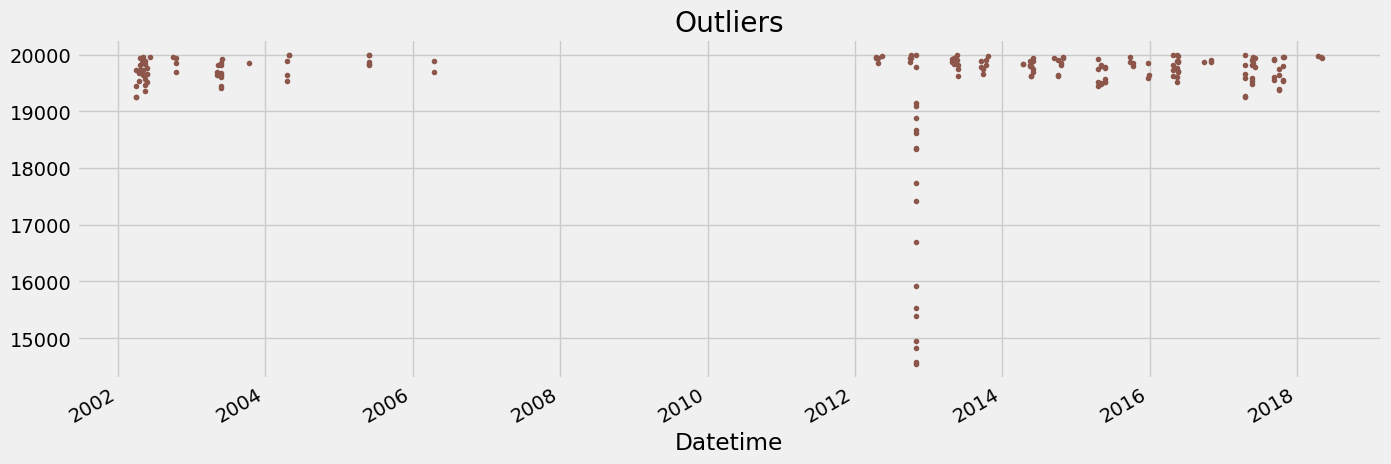

In [56]:
df.query('PJME_MW < 20_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

Most of the points are consistent, but some of them have a nasty behavior. 
- Maybe they are real values, but not usefull for predicting in the future.

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

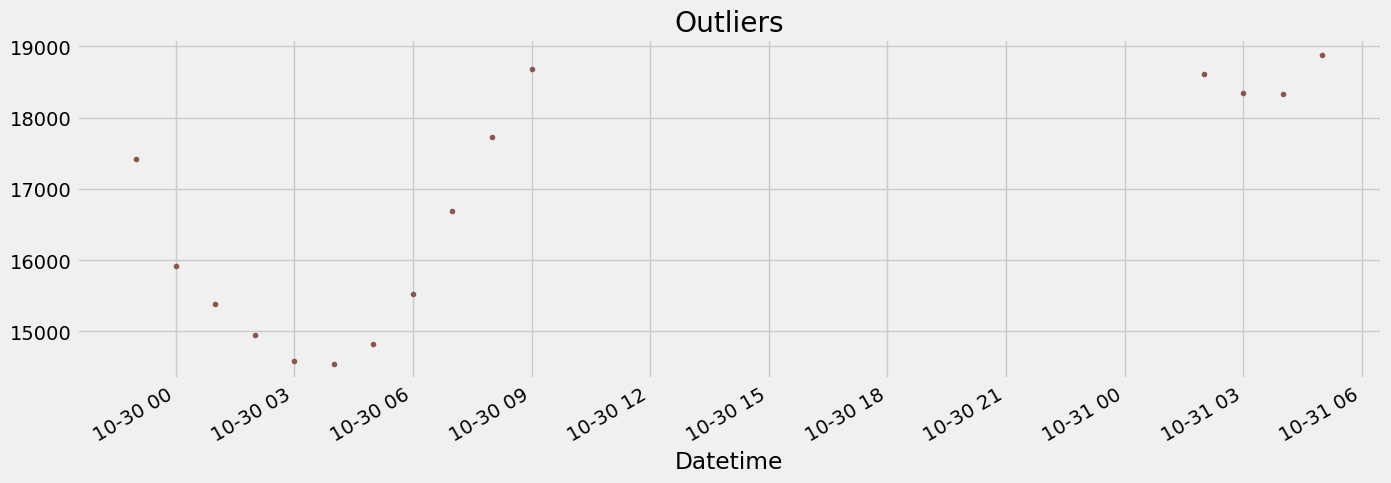

In [57]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [58]:
df = df.query('PJME_MW > 19_000').copy()

## Time Series Cross Validation

The traditional k-fold cross-validation approach is not suitable for time series data because it assumes that the data is independently and identically distributed, which is not true for time series data. 
- Instead, we need to use a modified form of cross-validation that takes into account the temporal dependencies in the data.

In [60]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

In [65]:
tss.split(df)

<generator object TimeSeriesSplit.split at 0x7fd13bcfb190>

It is generator ...

In [68]:
iterator = iter(tss.split(df))
train_range, test_range = next(iterator)
print(train_range)
print(test_range)

[     0      1      2 ... 101566 101567 101568]
[101593 101594 101595 ... 110350 110351 110352]


In [69]:
train_range, test_range = next(iterator)
print(train_range)
print(test_range)

[     0      1      2 ... 110326 110327 110328]
[110353 110354 110355 ... 119110 119111 119112]


In [70]:
train_range, test_range = next(iterator)
print(train_range)
print(test_range)

[     0      1      2 ... 119086 119087 119088]
[119113 119114 119115 ... 127870 127871 127872]


It is clearer in a graphical representation

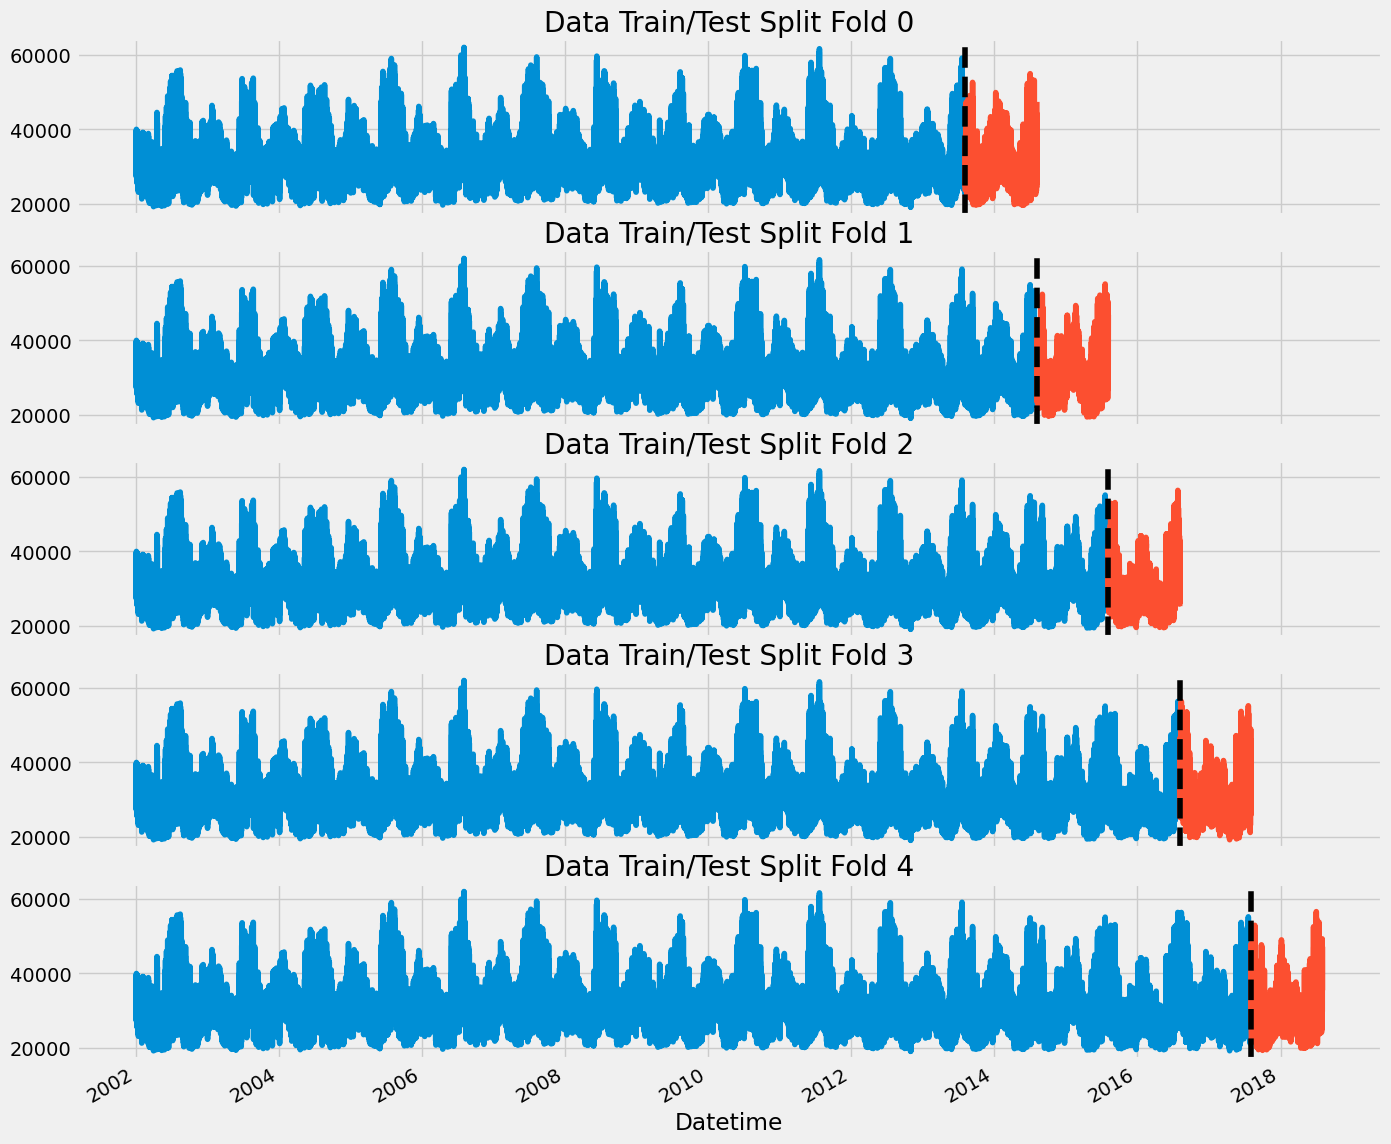

In [71]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Forecasting Horizon

The forecast horizon is the length of time into the future for which forecasts are to be prepared. 
- These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).

## Lag Features

In time series analysis, lag features are variables that represent past values of the time series variable being analyzed. 
- Lag features are used to capture the autocorrelation or dependency of the time series variable on its past values.

In [72]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

add_lags(df)

In [80]:
df[df.index > '2010-01-01'][['PJME_MW','lag1', 'lag2', 'lag3']].head()

,PJME_MW,lag1,lag2,lag3
Datetime,,,,
2010-01-01 01:00:00,30075.0,31630.0,35291.0,26152.0
2010-01-01 02:00:00,28907.0,30500.0,34450.0,25030.0
2010-01-01 03:00:00,27906.0,29880.0,34217.0,24449.0
2010-01-01 04:00:00,27373.0,29682.0,34318.0,24230.0
2010-01-01 05:00:00,27411.0,30072.0,35032.0,24701.0


## Using Lags and Cross Validation together

In [81]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[12:26:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32731.17798	validation_1-rmse:31989.02727
[100]	validation_0-rmse:12532.23442	validation_1-rmse:11933.13585
[200]	validation_0-rmse:5743.10258	validation_1-rmse:5353.66496
[300]	validation_0-rmse:3870.53529	validation_1-rmse:3862.46452
[400]	validation_0-rmse:3433.35539	validation_1-rmse:3707.72058
[454]	validation_0-rmse:3355.16599	validation_1-rmse:3710.02246
[12:26:20] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32671.76575	validation_1-rmse:32156.47517
[100]	validation_0-rmse:12513.30622	validation_1-rmse:12245.88651
[200]	validation_0-rmse:5755.24052	validation_1-rmse:5678.52353
[300]	validation_0-rmse:3903.74943	validation_1-rmse:3937.60443
[400]	validation_0-rmse:3476.16473	validation_1-rmse:3596.56727
[500]	validation_0-rmse:3354.72346	validation_1-rmse:3

In [82]:
scores

[3705.884409388113,
 3438.6289810109456,
 3457.061149100903,
 4089.0688974803784,
 3992.968000557776]

In [83]:
np.mean(scores)

3736.722287507623

Lets see the importance of the lag features for the last regressor

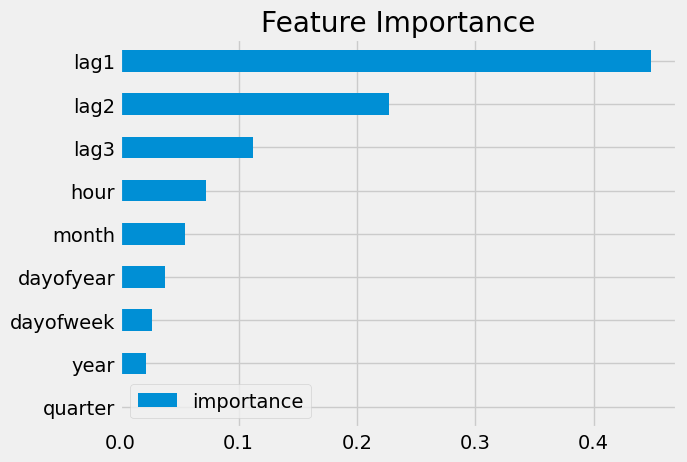

In [85]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

<Axes: xlabel='Datetime'>

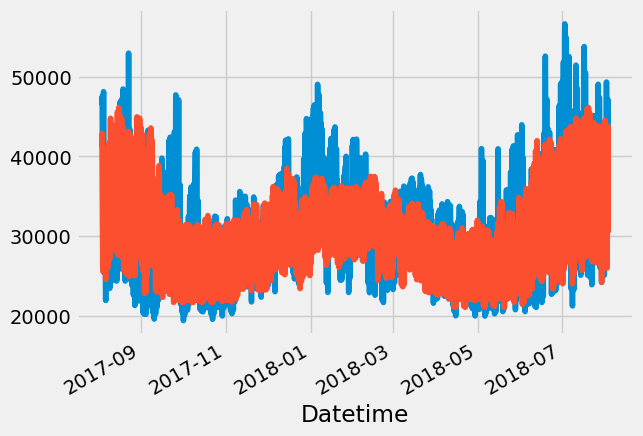

In [90]:
test['prediction'] = y_pred
test.PJME_MW.plot()
test.prediction.plot()

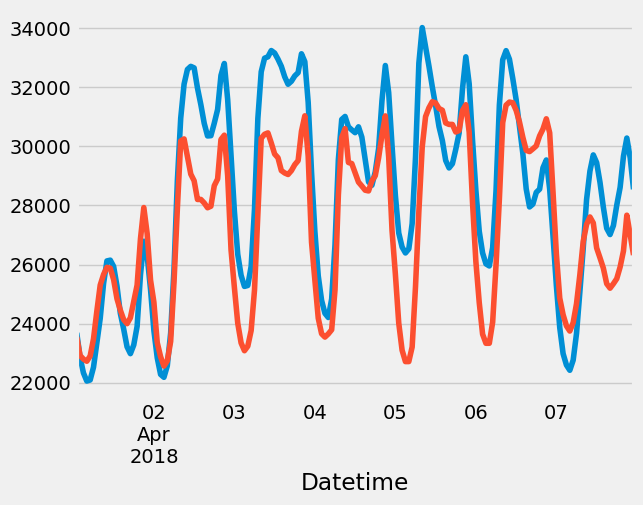

In [92]:
test[(test.index > '04-01-2018') & (test.index < '04-08-2018')].PJME_MW.plot()
test[(test.index > '04-01-2018') & (test.index < '04-08-2018')].prediction.plot()
plt.show()

## Predicting the Future

- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation